In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from uszipcode import ZipcodeSearchEngine
from geopy.geocoders import Nominatim

from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML

import pandas as pd
import seaborn.apionly as sns
from datetime import date, datetime
from haversine import haversine

# statistics package
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from random import randint
# packages for mapping
from mpl_toolkits.basemap import Basemap

# packages for interactive graphs
from ipywidgets import widgets, interact
from IPython.display import display
from copy import deepcopy as copy
import time
from geopy.geocoders import Nominatim

from time import sleep
import requests
import time,datetime
import os
import json
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\apionly.py:6: UserWarning:

As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
findzip = ZipcodeSearchEngine()

In [3]:
historical_data = pd.read_csv('clean_train_data.csv')

In [4]:
historical_data.head()

,Unnamed: 0,day_interval,distance,dropoff_date,dropoff_datetime,dropoff_hour,dropoff_latitude,dropoff_longitude,dropoff_zipcode,fare_amount,...,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,trip_time_in_secs,vendor_id,waiting_penalty,waiting_time,weather
0,186987.0,2,10.418191,2013-01-13,2013-01-13 20:58:00,20,40.793388,-73.972809,10025,27.0,...,0.5,5.5,4.8,38.3,9.06,1200,VTS,0.000000,0.000000,Rain
1,136205.0,2,0.376856,2013-01-13,2013-01-13 21:10:00,21,40.782097,-73.978867,10024,3.5,...,0.5,0.0,0.0,4.5,0.44,120,VTS,0.029670,21.362104,Rain
2,114412.0,2,0.996570,2013-01-13,2013-01-13 21:35:00,21,40.751007,-73.978104,10168,4.5,...,0.5,0.0,0.0,5.5,0.65,240,VTS,0.691434,497.832494,Rain
3,148407.0,2,4.608048,2013-01-13,2013-01-13 21:46:00,21,40.717236,-74.003563,10278,8.5,...,0.5,1.0,0.0,10.5,2.28,420,VTS,2.600077,1872.055354,Rain
4,114616.0,2,1.231572,2013-01-13,2013-01-13 22:15:00,22,40.739117,-73.987694,10010,4.5,...,0.5,1.0,0.0,6.5,0.91,180,VTS,4.437344,3194.887668,Rain


In [5]:
historical_data.keys()

Index(['Unnamed: 0', 'day_interval', 'distance', 'dropoff_date',
       'dropoff_datetime', 'dropoff_hour', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_zipcode', 'fare_amount', 'hack_license',
       'medallion', 'mta_tax', 'passenger_count', 'payment_type',
       'pickup_date', 'pickup_datetime', 'pickup_day', 'pickup_hour',
       'pickup_latitude', 'pickup_longitude', 'pickup_minute', 'pickup_time',
       'pickup_weekday', 'pickup_zipcode', 'rate_code', 'speed',
       'store_and_fwd_flag', 'surcharge', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_distance', 'trip_time_in_secs', 'vendor_id',
       'waiting_penalty', 'waiting_time', 'weather'],
      dtype='object')

## Preprocess

In [6]:
historical_data["dropoff_minute"] = pd.to_datetime(historical_data["dropoff_datetime"]).apply(lambda x: x.minute)
historical_data["dropoff_time"] =historical_data["dropoff_hour"] + (historical_data["dropoff_minute"] / 60)

## Reinforcement Model

In [7]:
class TaxiWorld():
    def __init__(self):
        self.waiting_penalty = 5.00
        pass
                
    def getReward(self, row):
        if row['waiting_time']/3600<=2:
            return row['total_amount'] - row['waiting_time']/3600*self.waiting_penalty
        else:
            return row['total_amount']
        
    
    def set_waiting_penalty(self, penalty):
        self.waiting_penalty = penalty
        
    def getState(self):
        print('Current State')
        return self.s
    
    def setState(self, s):
        self.s = s
        
    def getStateSize(self, trip_and_fare):
        return len(trip_and_fare['zip_code'].unique())
    
    def getZipCodes(self, trip_and_fare):
        return self.zip_codes
    
    def getActionSize(self):
        return len(self.actions)

    def nextAction(self, s):
        print('Calculate Next Action based on state')
        
    def check_Q_table(self, s):
        if s not in self.Q:
            self.Q[s] = dict((action, 0.0) for action in self.actions)
            

In [8]:
env = TaxiWorld()

In [9]:
class TaxiRevenue:
    def __init__(self, env, penalty=5.0, roaming_penalty=10, const=1000, Q_table_file_name='saved_Q.json'):
        self.env = env
        self.penalty=penalty
        self.roaming_penalty = roaming_penalty
        self.const=const
        self.env.set_waiting_penalty(penalty)
        self.Q = dict()
        self.dropPickMap= dict()
        self.Q_table_file_name = Q_table_file_name
        self.load_Q()
        
    def load_Q(self):
        if os.path.isfile(self.Q_table_file_name):
            with open(self.Q_table_file_name, 'r') as fp:
                self.Q = json.load(fp)
    
    def store_Q(self):
        with open(self.Q_table_file_name, 'w') as fp:
            json.dump(self.Q, fp)
        
    def generate_key(self, row):
        return str(row['pickup_zipcode']) + '_'  + str(row['pickup_weekday']) + '_' + str(row['day_interval']) + '_' + str(row['weather'])
    
    def get_tuples(self, key):
        tuples = key.split('_')
        return {'pickup_zipcode': tuples[0],
                   'pickup_weekday': tuples[1],
                   'day_interval': tuples[2],
                   'weather': tuples[3]}
    
    def calculate_penalty(self, pickup_tuple, taxidata):
        if int(pickup_tuple['pickup_zipcode'])!=taxidata['dropoff_zipcode']:
            dis=self.find_distance(taxidata['dropoff_zipcode'], int(pickup_tuple['pickup_zipcode']))
            time= dis/taxidata['speed']
            return time*self.roaming_penalty
        else: 
            return 0
                
        
    def get_meantriptime(self, data):
        map=historical_data.groupby(['pickup_zipcode', 'dropoff_zipcode'])['trip_time_in_secs'].mean()
        return map.reset_index()
    
    def isValidPickup(self, taxidata, dropPickMap):
        key=self.generate_key(taxidata)
        if key in dropPickMap:
            return True
        else:
            return False
        
    def generate_dropPickMap(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            if key not in self.dropPickMap:
                self.dropPickMap[key] = []
            if str([str(row['dropoff_zipcode']), row['total_amount']]) not in self.dropPickMap[key]:
                self.dropPickMap[key].append([str(row['dropoff_zipcode']), row['total_amount']])
        return self.dropPickMap
    
    def getDropoff(self, key, dropPickMap):
        posDropoff= dropPickMap[key]
#         print("dropoffs",posDropoff )
        rand=randint(0, len(posDropoff)-1)
        return posDropoff[rand][0], posDropoff[rand][1]
         
    def getDayInterval(self,hour):
        if hour>=6 and hour<12:
            return 0
        elif hour>=12 and hour<18:
            return 1
        elif hour>=18 and hour<24:
            return 2
        else:
            return 3
        
    def getAction(self, taxidata, _Q,dropPickMap):
        best_reward=0
        #best_key = 0
        s = self.generate_key(taxidata)
        best_key=s
        #print(taxidata)
        if s in _Q:
            best_reward=_Q[s][0]*_Q[s][1]/self.const
        
        zipcode=findzip.by_zipcode(taxidata['dropoff_zipcode'])
        temp=taxidata
        possible_pickup=[]
        returns=10
        radius=5
        while not possible_pickup:
            pickup_res = findzip.by_coordinate(zipcode['Latitude'], zipcode['Longitude'], radius=5, returns=returns)
            for i in range(len(pickup_res)):
                
                temp['pickup_zipcode']=pickup_res[i]['Zipcode']
                dis=self.find_distance(temp['dropoff_zipcode'], temp['pickup_zipcode'])
                time= dis/temp['speed']
                day_interval=self.getDayInterval(temp['dropoff_time']+time)
                temp['day_interval']= day_interval
                #print(temp['pickup_zipcode'])
                if self.isValidPickup(temp, dropPickMap):
                    possible_pickup.append(pickup_res[i]['Zipcode'])

#             print("valid pickup", possible_pickup)
            returns+=10
            radius+=1
        
        for key in _Q:
            tuples=self.get_tuples(key)
               
            
            if tuples['pickup_zipcode'] in possible_pickup and tuples['weather']==str(taxidata['weather']) and tuples['pickup_weekday']==str(taxidata['pickup_weekday']) and tuples['day_interval']==str(taxidata['day_interval']):
            
                tempReward=_Q[key][0]*_Q[key][1]/self.const-self.calculate_penalty(tuples, taxidata)
                
                if tempReward>best_reward:
                    #print("in temp reward: ",tempReward)
                    #print("in best reward: ",best_reward)
                    best_key=key
                    best_reward= tempReward
                    #print(self.get_tuples(best_key))
                    
        return best_key
    
    def build_Q_table(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            reward = self.env.getReward(row)
            if key not in self.Q:
                self.Q[key] = [reward,1]
            else:
                self.Q[key] = [self.Q[key][0] +reward, self.Q[key][1] + 1]
    
    def get_Q_table(self):
        return self.Q
        
    def train(self, trip_and_fare, Q_table_file_name =  'saved_Q.json'):
        self.Q_table_file_name = Q_table_file_name
        self.build_Q_table(trip_and_fare)
        self.store_Q()
        return self.Q
        
    def distance(self, lat1, lon1, lat2, lon2):
        """calculates the Manhattan distance between 2 points
            using their coordinates

        Parameters
        ----------
        lat1: float
            latitude of first point

        lon1: float
            longitude of first point

        lat2: float
            latitude of second point

        lon2: float
            longitude of second point

        Returns
        -------
        d: float
            The Manhattan distance between the two points in kilometers

        """

        d = haversine((lat1, lon1), (lat2, lon1)) + haversine((lat2, lon1), (lat2, lon2))
        return d
    
    def find_distance(self, zip1, zip2):
        zipcode1=findzip.by_zipcode(zip1)
        zipcode2=findzip.by_zipcode(zip2)
        dis=self.distance(zipcode1['Latitude'], zipcode1['Longitude'],zipcode2['Latitude'], zipcode2['Longitude'])
        return dis
    
    def get_random_driver_data(self, taxidata):
        # Get data of a random driver for a day
        total_driver = taxidata['hack_license'].unique()
        driver_index = randint(0, (total_driver.shape[0]-1))
        driver_ID = total_driver[driver_index]
        selected_driver_data = copy(taxidata[taxidata['hack_license'] == driver_ID])
       
        available_day = selected_driver_data['pickup_day'].unique()
        day_num = available_day[randint(0, (available_day.shape[0]-1))]
        selected_driver_data = selected_driver_data[selected_driver_data['pickup_day'] == day_num]
        selected_driver_data = selected_driver_data.sort_values(by=['pickup_datetime'], ascending=True)        
        return selected_driver_data
    
    def get_testRowAndHistIncome(self, taxidata):
        # Find a driver, and get his income for 12 hour
        var = 0                    
        while var < 30:   
            var = var +1;
            driver_data = self.get_random_driver_data(taxidata)
        #    # Keep in mind, very few drivers drive both late-night and morning. So not much data
        #     if (driver_data.iloc[0]['day_interval']==0 | driver_data.iloc[0]['day_interval']==3):
            # If we consider only morning shift
            if (driver_data.iloc[0]['day_interval']==0) and (driver_data.iloc[-1]['dropoff_time']-driver_data.iloc[0]['pickup_time'])>=8.0:
                break
        # Consider only the 1st 12 hours
        starting_dropoff_hour = driver_data.iloc[0]['dropoff_time']
        driver_data =driver_data[driver_data['dropoff_time'] <= (starting_dropoff_hour +12)]

        # print(driver_data)
        income_of_historical_data = driver_data['total_amount'].sum()
        travel_hour = driver_data.iloc[-1]['dropoff_time']-driver_data.iloc[0]['pickup_time']
        return driver_data.iloc[0], income_of_historical_data, travel_hour, driver_data
    
    def test(self, taxidata, _Q, dropPickMap,meanTrip, travel_time=12, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        curr_dropoff_hour=taxidata['dropoff_time']
        #curr_pickup=taxidata['dropoff_time']
        end_time=curr_dropoff_hour+ travel_time
        
        traces = []
        rewards = []
        while curr_dropoff_hour <= end_time:
            
            best_key=self.getAction( taxidata, _Q,dropPickMap)
            pickup_tuple= self.get_tuples(best_key)
            dis = 0
            waiting_time = randint(10000,90800)/(3600*_Q[best_key][1])
            if int(pickup_tuple['pickup_zipcode'])!=taxidata['dropoff_zipcode']:
                dis=self.find_distance(taxidata['dropoff_zipcode'], int(pickup_tuple['pickup_zipcode']))
            curr_dropoff_hour+= dis/taxidata['speed']+ waiting_time
            print("roaming time", str(datetime.timedelta(seconds = (dis/taxidata['speed'] + waiting_time)*3600)) )
            dropoff, reward=self.getDropoff(best_key, dropPickMap)
                
            print("going from ",pickup_tuple['pickup_zipcode'], " to ",  dropoff, " at ", time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600)), ' fare cost: ', reward)
            trace = {
                'roaming_time': str(datetime.timedelta(seconds = dis/taxidata['speed']*3600)),
                'start_position': pickup_tuple['pickup_zipcode'],
                'destination': dropoff,
                'income': reward,
                'current_time': time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600))
            }
            traces.append(trace)
            rewards.append(reward)
            #curr_dropoff=curr_dropoff+meanTrip[meanTrip['pickup_zipcode']]
            #print(pickup_tuple['pickup_zipcode'])
            temptrip = meanTrip[(meanTrip['pickup_zipcode']==int(pickup_tuple['pickup_zipcode'])) & (meanTrip['dropoff_zipcode']==int(dropoff))]
            meanTripTime= temptrip.iloc[0]['trip_time_in_secs']
            #print(meanTripTime)
            
            curr_dropoff_hour=curr_dropoff_hour+meanTripTime/3600
            taxidata['dropoff_zipcode']=int(dropoff)
            taxidata['day_interval']=self.getDayInterval(curr_dropoff_hour)
        print('Done')
        return traces, rewards

## Train the Model

In [10]:
taxiRevenue = TaxiRevenue(env, 5.0, 10, 1000,  'saved_Q.json')

In [203]:
_Q = taxiRevenue.train(historical_data)

In [11]:
_Q = taxiRevenue.get_Q_table()
len(_Q)

5496

## Generate Test Data

In [20]:
dropPickMap=taxiRevenue.generate_dropPickMap(historical_data)
meanTrip= taxiRevenue.get_meantriptime(historical_data)

In [12]:
# meanTrip = pd.read_csv('meanTrip.csv')
# with open('dropPickMap.json', 'r') as fp:
#         dropPickMap = json.load(fp)

## Test The Model with Historical Data

In [13]:
def run_test_suite(_model, data_set, Q_table, dropPickMap, meanTrip, num_of_test_run=3):
    testcases = []
    for i in range(num_of_test_run):
        test_row, income_of_historical_data, travel_hour, hist_data = _model.get_testRowAndHistIncome(data_set)
        print('********* Test run: #', i+1, ' ***********')
        traces, income_of_model = _model.test(test_row, Q_table, dropPickMap, meanTrip, travel_hour)
        testcases.append({'traces': traces, 'hist_traces':hist_data, 'income_of_model': np.sum(income_of_model), 'income_of_historical_data':income_of_historical_data, 'hour_spend':travel_hour})
        print('Income of the Historical Data: ', income_of_historical_data)
        print('Income of the Model: ', np.sum(income_of_model))
        print('Total hour spend: ', np.sum(travel_hour))
        print('********* End of test run: #', i+1, '*********')
        pass
    return testcases
        
        

In [38]:
data_set = copy(historical_data)
testcases = run_test_suite(taxiRevenue, data_set,_Q, dropPickMap, meanTrip, 5)

********* Test run: # 1  ***********


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



roaming time 0:16:07.123882
going from 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:248: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:249: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



 11430  to  11211  at  02:39:07  fare cost:  67.7
roaming time 0:06:31.000941
going from  11201  to  10003  at  03:18:20  fare cost:  17.3
roaming time 0:04:08.193037
going from  10119  to  10019  at  03:36:31  fare cost:  13.0
roaming time 0:02:53.262925
going from  10020  to  10018  at  03:49:09  fare cost:  5.5
roaming time 0:01:00.510288
going from  10119  to  10021  at  03:56:26  fare cost:  11.0
roaming time 0:01:43.917016
going from  10065  to  10075  at  04:12:57  fare cost:  5.0
roaming time 0:02:31.738241
going from  10065  to  11371  at  04:20:24  fare cost:  28.5
roaming time 0:00:17.234261
going from  11371  to  10010  at  04:40:29  fare cost:  36.62
roaming time 0:03:42.946250
going from  10119  to  10016  at  05:03:48  fare cost:  7.5
roaming time 0:02:24.337280
going from  10119  to  10012  at  05:13:38  fare cost:  13.0
roaming time 0:05:18.606204
going from  10119  to  10011  at  05:29:57  fare cost:  8.3
roaming time 0:02:58.779645
going from  10119  to  11371  at  0

roaming time 0:02:51.357724
going from  10021  to  10111  at  11:59:46  fare cost:  9.5
roaming time 0:01:41.509047
going from  10020  to  10128  at  12:10:39  fare cost:  12.0
roaming time 0:02:18.523971
going from  10028  to  10128  at  12:24:39  fare cost:  6.5
roaming time 0:02:21.274133
going from  10028  to  10028  at  12:31:22  fare cost:  6.5
roaming time 0:00:03.877349
going from  10028  to  10075  at  12:35:42  fare cost:  5.0
roaming time 0:07:07.724563
going from  10023  to  10028  at  12:47:14  fare cost:  14.5
roaming time 0:00:02.504699
going from  10028  to  10016  at  12:57:48  fare cost:  20.3
roaming time 0:04:08.744687
going from  10119  to  10010  at  13:14:32  fare cost:  4.5
roaming time 0:06:22.928896
going from  10119  to  10036  at  13:27:45  fare cost:  8.75
Done
Income of the Historical Data:  330.9
Income of the Model:  550.12
Total hour spend:  11.966666666666669
********* End of test run: # 2 *********
********* Test run: # 3  ***********
roaming time 0:0

roaming time 0:00:43.689086
going from  10022  to  10021  at  10:51:16  fare cost:  14.5
roaming time 0:01:36.564900
going from  10065  to  10199  at  10:58:30  fare cost:  23.0
roaming time 0:00:45.421768
going from  10119  to  10011  at  11:15:12  fare cost:  6.5
roaming time 0:02:49.049565
going from  10119  to  10165  at  11:23:51  fare cost:  9.5
roaming time 0:04:36.987388
going from  10003  to  10010  at  11:36:00  fare cost:  12.5
roaming time 0:03:30.617351
going from  10119  to  10018  at  11:44:55  fare cost:  7.2
roaming time 0:00:57.003196
going from  10119  to  10112  at  11:51:53  fare cost:  9.6
roaming time 0:00:38.147710
going from  10020  to  11369  at  11:59:39  fare cost:  39.8
roaming time 0:00:21.721515
going from  11369  to  10278  at  12:27:43  fare cost:  42.0
roaming time 0:02:38.954810
going from  10012  to  10019  at  12:57:30  fare cost:  14.5
roaming time 0:02:42.041688
going from  10020  to  10007  at  13:16:09  fare cost:  16.5
Done
Income of the Histor

## Show the One Taxi Driver Traces in New York Map

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.



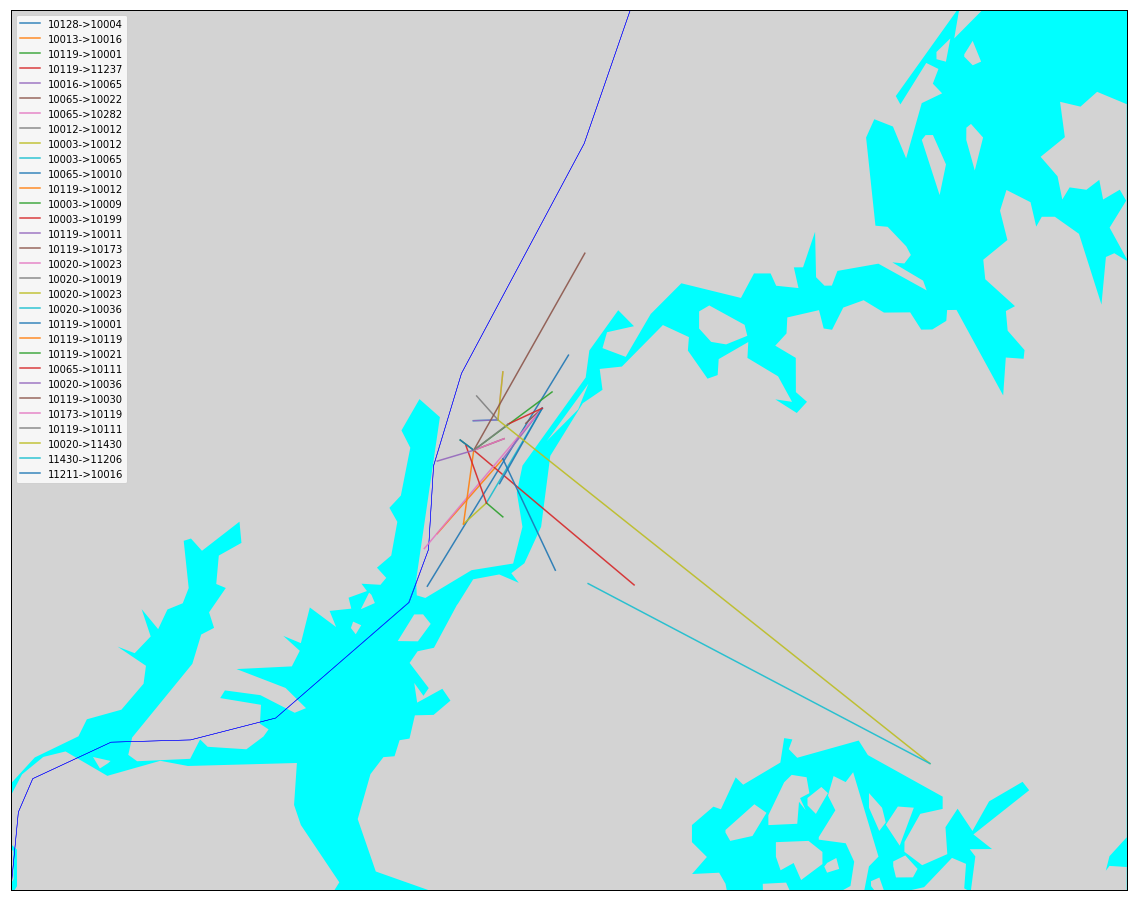

In [55]:
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
plt.figure(figsize=(20,20))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.6
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

map = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max, resolution='h', projection='tmerc', lat_0 = cent_lat, lon_0 = cent_lon, area_thresh = 0.1)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='lightgray', lake_color='aqua')
map.drawcountries(linewidth=2)
map.drawstates(color='b')

for trace in testcases[1]['traces']:
    long = []
    lat = []
    start_position = trace['start_position']
    res = findzip.by_zipcode(start_position)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    
    destination = trace['destination']
    res = findzip.by_zipcode(destination)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    x, y = map(long, lat)
    plt.plot(x, y, '-', label=str(start_position)+'->'+str(destination), markersize=10, alpha=0.9)

plt.legend()

## Show Animated Traverse on a Particular Driver taces

In [56]:
init_notebook_mode(connected=True)

long = []
lat = []
lat_list = []
lon_list = []
traces = testcases[1]['traces']
for i in range(len(traces)):
    src = findzip.by_zipcode(traces[i]['start_position'])
    dst = findzip.by_zipcode(traces[i]['destination'])
    long.append({'src':src['Longitude'], 'dst': dst['Longitude']})
    lat.append({'src':src['Latitude'], 'dst': dst['Latitude']})
    lat_list.append(src['Latitude'])
    lat_list.append(dst['Latitude'])
    lon_list.append(src['Longitude'])
    lon_list.append(dst['Longitude'])

data = []
frames = []
for i in range(len(lat)):
    x = []
    y = []
    xx = []
    yy = []
    s = []
    new_point = True
    N=5
    if long[i]['src'] == long[i]['dst'] or lat[i]['src'] == lat[i]['dst']:
        x = np.linspace(long[i]['src'], long[i]['dst'], 100)
        y = np.linspace(lat[i]['src'], lat[i]['dst'], 100)

        xx=np.linspace(long[i]['src'], long[i]['dst'],N)
        yy = np.linspace(lat[i]['src'], lat[i]['dst'], 100)
    else:
        x = np.linspace(long[i]['src'], long[i]['dst'], 100)
        m = (lat[i]['src'] - lat[i]['dst'])/(long[i]['src']-long[i]['dst'])
        y = m*(x-long[i]['dst']) + lat[i]['dst']

        xx=np.linspace(long[i]['src'], long[i]['dst'],N)
        yy = m*(xx - long[i]['dst']) + lat[i]['dst']


    data.append(dict(x=x, y=y, 
               mode='lines', 
               line=dict(width=2)
              ))
    data.append(dict(x=x, y=y, 
               mode='lines', 
               line=dict(width=2)
              ))

    color = ''
    for k in range(N):
        if new_point:
            r = lambda: randint(0,255)
            color = '#%02X%02X%02X' % (r(),r(),r())
            new_point = False
        frames.append(dict(data=[dict(x=[xx[k]], 
                            y=[yy[k]], 
                            mode='markers', 
                            marker=dict(color=color, size=15)
                            )
                      ])) 
lat_min = np.min(lat_list) - 0.05 #40.65
lat_max = np.max(lat_list) + 0.05 #40.85
lon_min = np.min(lon_list) - 0.05 #-74.1
lon_max = np.max(lon_list) + 0.05 #-73.8
layout=dict(xaxis=dict(range=[lon_min, lon_max], autorange=False, zeroline=False),
            yaxis=dict(range=[lat_min, lat_max], autorange=False, zeroline=False),
            title='Traces for Taxi in a Particular Day', hovermode='closest',
            updatemenus= [{'type': 'buttons',
                           'buttons': [{'label': 'Play',
                                        'method': 'animate',
                                        'args': [None]}]}])

figure1=dict(data=data, layout=layout,  frames=frames)          
iplot(figure1, 'points_changing_size'+str(time.time()))

## Compare Historical Income and Proposed Model

In [42]:
result_set = pd.DataFrame(columns=['Roaming Hour', 'Historical Data Income', 'Model Income'])

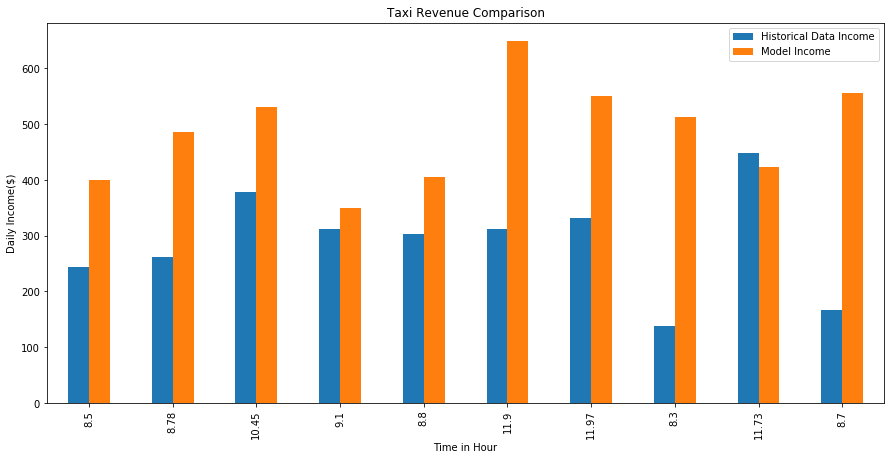

In [50]:
_model_income = []
_hist_income = []
_roaming_hr = []
for testcase in testcases:
    _model_income.append(testcase['income_of_model'])
    _hist_income.append(testcase['income_of_historical_data'])
    _roaming_hr.append(float(("%0.2f"%testcase['hour_spend'])))
    pass
result_set['Model Income'] = _model_income
result_set['Historical Data Income'] = _hist_income
result_set['Roaming Hour'] = _roaming_hr
result_set.plot(kind='bar', x ='Roaming Hour', figsize=(15, 7), title='Taxi Revenue Comparison', legend =True)
plt.ylabel('Daily Income($)')
plt.xlabel('Time in Hour')
plt.show()

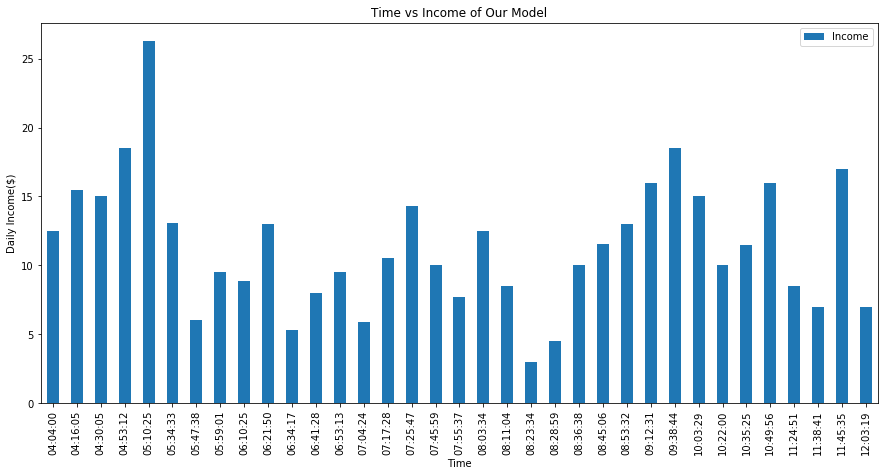

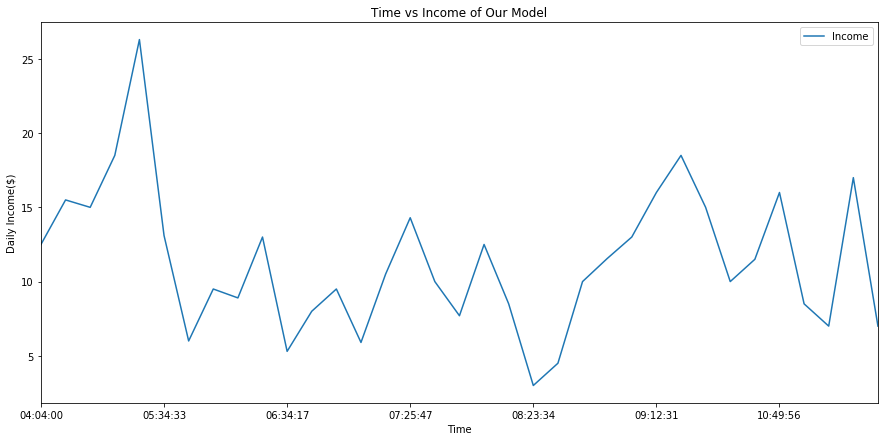

In [46]:
daily_income = pd.DataFrame(columns=['Time', 'Income'])
_income = []
_time = []
for trace in testcases[0]['traces']:
    _time.append(trace['current_time'])
    _income.append(trace['income'])
    pass
daily_income['Time'] = _time
daily_income['Income'] = _income
daily_income.plot(kind='bar', x ='Time', figsize=(15, 7), title='Time vs Income of Our Model', legend =True)
plt.ylabel('Daily Income($)')
plt.xlabel('Time')
plt.show()
daily_income.plot(kind='line', x ='Time', figsize=(15, 7), title='Time vs Income of Our Model', legend =True)
plt.ylabel('Daily Income($)')
plt.xlabel('Time')
plt.show()

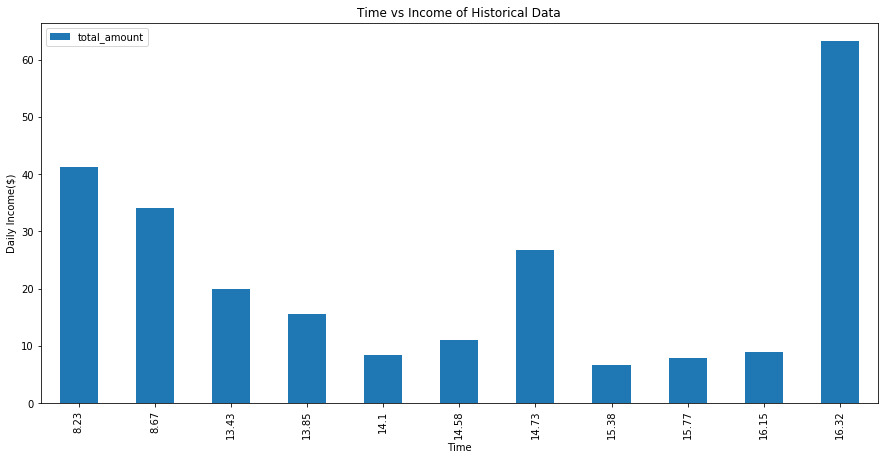

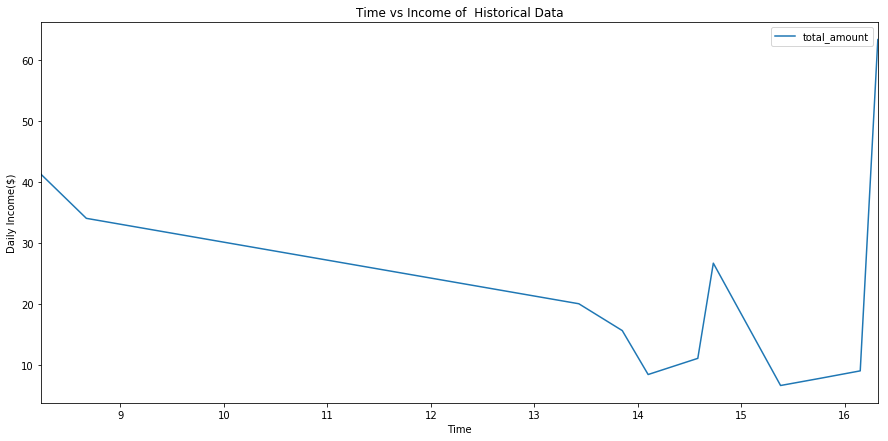

In [47]:

testcases[0]['hist_traces']['pickup_time'] = testcases[0]['hist_traces']['pickup_time'].apply(lambda x: float(("%0.2f"%x)))
testcases[0]['hist_traces'].plot(kind='bar', x ='pickup_time', y='total_amount', figsize=(15, 7), title='Time vs Income of Historical Data', legend =True)
plt.ylabel('Daily Income($)')
plt.xlabel('Time')
plt.show()
testcases[0]['hist_traces'].plot(kind='line', x ='pickup_time', y='total_amount', figsize=(15, 7), title='Time vs Income of  Historical Data', legend =True)
plt.ylabel('Daily Income($)')
plt.xlabel('Time')
plt.show()

In [86]:
result_set['Revenue Increase'] = None
percentage = []
for index,row in result_set.T.iteritems():
    percentage.append(str(float(("%0.2f"%((row['Model Income'] - row['Historical Data Income'])*100/row['Historical Data Income'])))) + '%')

result_set['Revenue Increase'] = percentage

In [85]:
result_set

,Roaming Hour,Historical Data Income,Model Income,Revenue Increase
0,8.50,243.65,399.05,63.78%
1,8.78,261.30,485.07,85.64%
2,10.45,379.09,531.06,40.09%
3,9.10,311.31,349.60,12.3%
4,8.80,303.65,404.37,33.17%
5,11.90,312.22,649.45,108.01%
6,11.97,330.90,550.12,66.25%
7,8.30,138.00,511.95,270.98%
8,11.73,447.42,422.31,-5.61%
9,8.70,167.56,555.85,231.73%
